# Book Recommendation System Using Clustering 


##  Setup and Imports

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors


In [3]:
# Define book category mapping (from Cote codes)
CATEGORY_MAPPING = {
    '004': "Informatique générale",
    '005': "Programmation / logiciels",
    '006': "Intelligence artificielle",
    '150': "Psychologie",
    '230': "Christianisme / religion",
    '350': "Administration publique",
    '380': "Commerce / communication",
    '510': "Mathématiques générales",
    '511': "Principes généraux des maths",
    '512': "Algèbre",
    '515': "Analyse / calcul",
    '518': "Méthodes numériques",
    '519': "Probabilités et statistiques",
    '570': "Sciences de la vie",
    '610': "Médecine / santé",
    '611': "Anatomie",
    '616': "Maladies / pathologie",
    '621': "Génie / ingénierie",
    '658': "Gestion / management",
    '681': "Informatique appliquée",
    '808': "Techniques d'écriture"
}


## Load and  Data

In [4]:
# Load borrowing data
df_borrowing = pd.read_excel('../data/cleaned_borrowings.xlsx')
#df_borrowing = pd.read_csv('../data/borrowing_test_data.csv')

In [5]:
# Basic statistics
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Total borrowing records: {len(df_borrowing):,}")
print(f"Unique borrowers: {df_borrowing['N° lecteur'].nunique():,}")
print(f"Unique books: {df_borrowing['Numéro'].nunique():,}")
print(f"\nBorrower categories:")
print(df_borrowing['Catégorie'].value_counts())
print(f"\nAverage borrowing duration: {df_borrowing['borrowing duration'].mean():.2f} days")

DATASET OVERVIEW
Total borrowing records: 422
Unique borrowers: 271
Unique books: 422

Borrower categories:
Catégorie
1 ére ANNEE    199
2 éme ANNEE    132
3 ème ANNEE     49
4 éme ANNEE     21
Enseignant      19
Employé          2
Name: count, dtype: int64

Average borrowing duration: 16.27 days


## Feature Engineering: Extract Book Categories from Cote

Here we want to extract category code ( 512 , 504 ..) from the cote  (510.BAL/2 ..) wich contains the category code + author 

In [6]:
def extract_category_from_cote(cote):
    if pd.isna(cote):
        return None
    
    cote_str = str(cote).strip()
    
    # Extract first 3 digits
    for key in CATEGORY_MAPPING.keys():
        if cote_str.startswith(key):
            return key
    
    return 'OTHER'

# Apply category extraction
df_borrowing['book_category'] = df_borrowing['Cote'].apply(extract_category_from_cote)

print("Category distribution:")
print(df_borrowing['book_category'].value_counts())

# Map to readable names
df_borrowing['category_name'] = df_borrowing['book_category'].map(CATEGORY_MAPPING)
df_borrowing['category_name'].fillna('Other', inplace=True)


Category distribution:
book_category
512      146
510       75
515       47
005       46
519       35
004       19
006       11
511        7
621        5
518        4
OTHER      2
658        2
570        2
616        1
610        1
611        1
380        1
350        1
150        1
681        1
Name: count, dtype: int64


C:\Users\DELL\AppData\Local\Temp\ipykernel_3620\4232197420.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_borrowing['category_name'].fillna('Other', inplace=True)


## Create User Profile Table

we used the borrowing table , wich contains borrowings record , to create user profile table wich contains information about each borrower ( Catégorie	, total_borrowed , avg_duration and also the percentage of interest in each categry )

In [7]:
def create_user_profiles(df):
    profiles = []
    
    for borrower_id in df['N° lecteur'].unique():
        user_data = df[df['N° lecteur'] == borrower_id]
        
        profile = {
            'N° lecteur': borrower_id,
            'Nom': user_data['Nom'].iloc[0],
            'Prénom': user_data['Prénom'].iloc[0],
            'Catégorie': user_data['Catégorie'].iloc[0],
            'total_borrowed': len(user_data),
            'avg_duration': user_data['borrowing duration'].mean(),
            'diversity_score': user_data['book_category'].nunique()
        }
        
        # Calculate percentage for each category
        category_counts = user_data['book_category'].value_counts()
        total_books = len(user_data)
        
        for category in CATEGORY_MAPPING.keys():
            count = category_counts.get(category, 0)
            profile[f'cat_{category}_pct'] = (count / total_books) * 100
        
        profiles.append(profile)
    
    return pd.DataFrame(profiles)

# Create user profiles
df_profiles = create_user_profiles(df_borrowing)

print(f"\nCreated profiles for {len(df_profiles)} users")
print(f"Profile shape: {df_profiles.shape}")
df_profiles.head()


Created profiles for 271 users
Profile shape: (271, 28)


,N° lecteur,Nom,Prénom,Catégorie,total_borrowed,avg_duration,diversity_score,cat_004_pct,cat_005_pct,cat_006_pct,...,cat_518_pct,cat_519_pct,cat_570_pct,cat_610_pct,cat_611_pct,cat_616_pct,cat_621_pct,cat_658_pct,cat_681_pct,cat_808_pct
0,5817912,MAMECHE,FERIEL,1 ére ANNEE,3,15.0,2,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5754033,fourali,malak,1 ére ANNEE,3,17.0,3,0.0,33.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5113394,SEHALI,MAYA,1 ére ANNEE,2,15.0,2,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6092419,kheddaoui,thiziri,1 ére ANNEE,2,15.0,2,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8354464,GACEB,RIHAM BAHIA,3 ème ANNEE,2,7.0,2,0.0,0.000000,0.0,...,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df_profiles.columns

Index(['N° lecteur', 'Nom', 'Prénom', 'Catégorie', 'total_borrowed',
       'avg_duration', 'diversity_score', 'cat_004_pct', 'cat_005_pct',
       'cat_006_pct', 'cat_150_pct', 'cat_230_pct', 'cat_350_pct',
       'cat_380_pct', 'cat_510_pct', 'cat_511_pct', 'cat_512_pct',
       'cat_515_pct', 'cat_518_pct', 'cat_519_pct', 'cat_570_pct',
       'cat_610_pct', 'cat_611_pct', 'cat_616_pct', 'cat_621_pct',
       'cat_658_pct', 'cat_681_pct', 'cat_808_pct'],
      dtype='object')

## Prepare Features for Clustering 

here we created a new table which we ar gonna use in the clustering which contains : behavioral features , interest percentage ,in addition to the features that represent the category of the borrower ( 1st year , 2nd...) which implimented using one-hot encoding 

In [9]:
# One-hot encode reader category
reader_categories_dummies = pd.get_dummies(df_profiles['Catégorie'], prefix='reader_cat')

print("Reader category one-hot encoded features:")
print(reader_categories_dummies.columns.tolist())

# Select percentage columns
pct_columns = [col for col in df_profiles.columns if col.endswith('_pct')]

# Combine all features
behavioral_features = [
    'total_borrowed',
    'avg_duration',
    'diversity_score'
]

# Create feature matrix
X_behavioral = df_profiles[behavioral_features + pct_columns].copy()
X_full = pd.concat([X_behavioral, reader_categories_dummies], axis=1)

print(f"\nFinal feature matrix shape: {X_full.shape}")
print(f"Features: {X_full.shape[1]} total")
print(f"  - Behavioral: {len(behavioral_features)}")
print(f"  - Category percentages: {len(pct_columns)}")
print(f"  - Reader category (one-hot): {reader_categories_dummies.shape[1]}")


Reader category one-hot encoded features:
['reader_cat_1 ére ANNEE', 'reader_cat_2 éme ANNEE', 'reader_cat_3 ème ANNEE', 'reader_cat_4 éme ANNEE', 'reader_cat_Employé', 'reader_cat_Enseignant']

Final feature matrix shape: (271, 30)
Features: 30 total
  - Behavioral: 3
  - Category percentages: 21
  - Reader category (one-hot): 6


In [10]:
X_full.head()

,total_borrowed,avg_duration,diversity_score,cat_004_pct,cat_005_pct,cat_006_pct,cat_150_pct,cat_230_pct,cat_350_pct,cat_380_pct,...,cat_621_pct,cat_658_pct,cat_681_pct,cat_808_pct,reader_cat_1 ére ANNEE,reader_cat_2 éme ANNEE,reader_cat_3 ème ANNEE,reader_cat_4 éme ANNEE,reader_cat_Employé,reader_cat_Enseignant
0,3,15.0,2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,True,False,False,False,False,False
1,3,17.0,3,0.0,33.333333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,True,False,False,False,False,False
2,2,15.0,2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,True,False,False,False,False,False
3,2,15.0,2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,True,False,False,False,False,False
4,2,7.0,2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,False,False,True,False,False,False


This is our final full table , before we do clustering we need to scale the values to ensure that variables with large numerical ranges do not outweigh smaller-scale features

In [11]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

## K-Means Clustering

In [12]:
# Elbow method and evaluation metrics for K-Means
inertias = []
silhouette_scores = []
db_scores = []
ch_scores = []
K_range = range(2, 11)

print("Testing K-Means with different numbers of clusters...\n")

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(sil_score)
    
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.3f}")

Testing K-Means with different numbers of clusters...



c:\Users\DELL\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMe

k=2: Inertia=6915.09, Silhouette=0.185
k=3: Inertia=6565.68, Silhouette=0.201
k=4: Inertia=6143.52, Silhouette=0.241
k=5: Inertia=5941.85, Silhouette=0.200
k=6: Inertia=5660.65, Silhouette=0.209
k=7: Inertia=5319.30, Silhouette=0.223
k=8: Inertia=5010.51, Silhouette=0.234
k=9: Inertia=4712.36, Silhouette=0.250
k=10: Inertia=4480.19, Silhouette=0.239


c:\Users\DELL\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


C:\Users\DELL\AppData\Local\Temp\ipykernel_3620\703235355.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[ 1].legend()


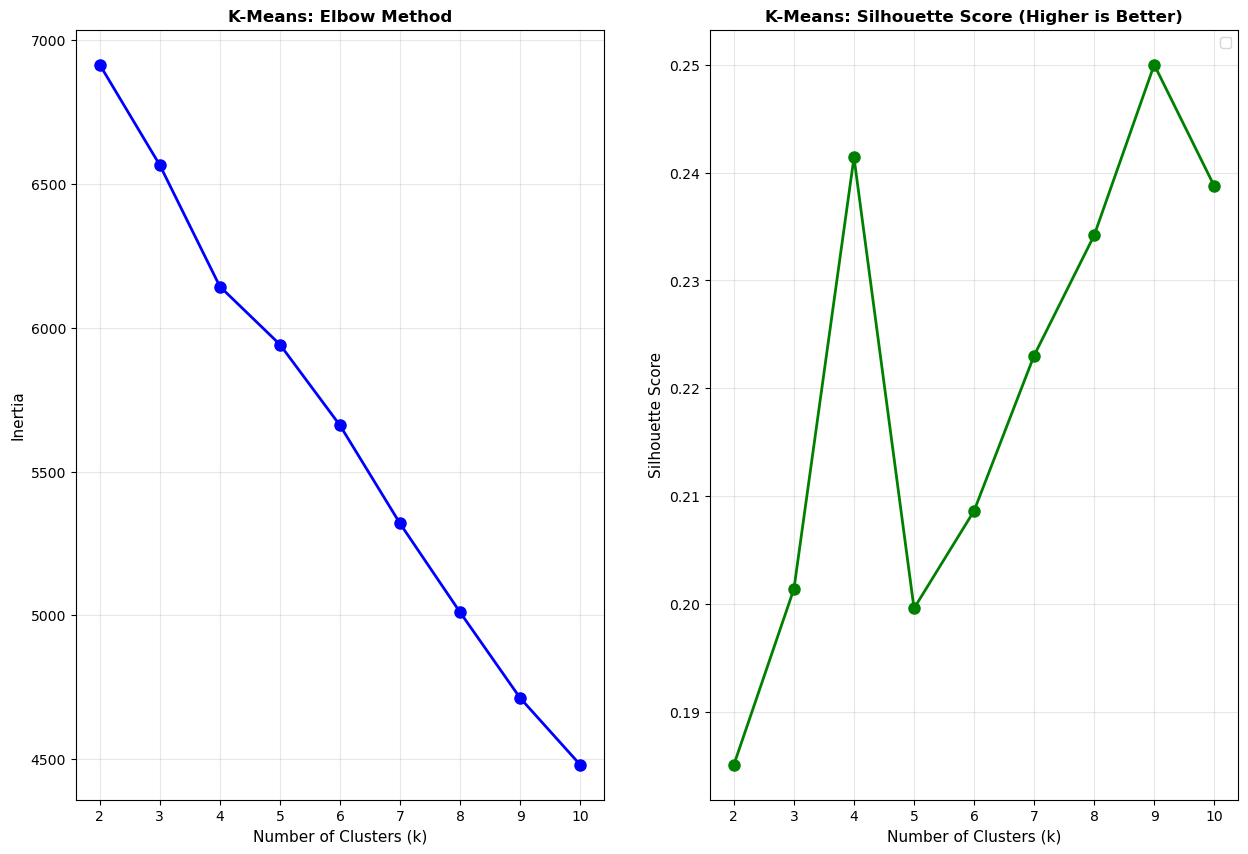

In [13]:
# Plot K-Means evaluation metrics
fig, axes = plt.subplots(1,2, figsize=(15, 10))

# Elbow plot
axes[ 0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[ 0].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[ 0].set_ylabel('Inertia', fontsize=11)
axes[ 0].set_title('K-Means: Elbow Method', fontsize=12, fontweight='bold')
axes[ 0].grid(True, alpha=0.3)

# Silhouette score
axes[ 1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[ 1].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[ 1].set_ylabel('Silhouette Score', fontsize=11)
axes[ 1].set_title('K-Means: Silhouette Score (Higher is Better)', fontsize=12, fontweight='bold')
axes[ 1].legend()
axes[ 1].grid(True, alpha=0.3)



Now we sould choose the number of clusters :
1. **elbow method** : here the elbow method is not helping us a lot , this is maybe because There is no natural cluster structure and the data does not strongly prefer a specific K . 
2. **Silhoutte score** : we used this to know the evaluation score of our clustering , for a specific K 

=> from the plots we can see that **K=10** is a good choice ( height score )

In [14]:
#optimal k
optimal_k = 9


## DBSCAN Clustering 

Plot k-distance graph to help determine eps parameter for DBSCAN. The 'elbow' point in this graph suggests a good eps value.

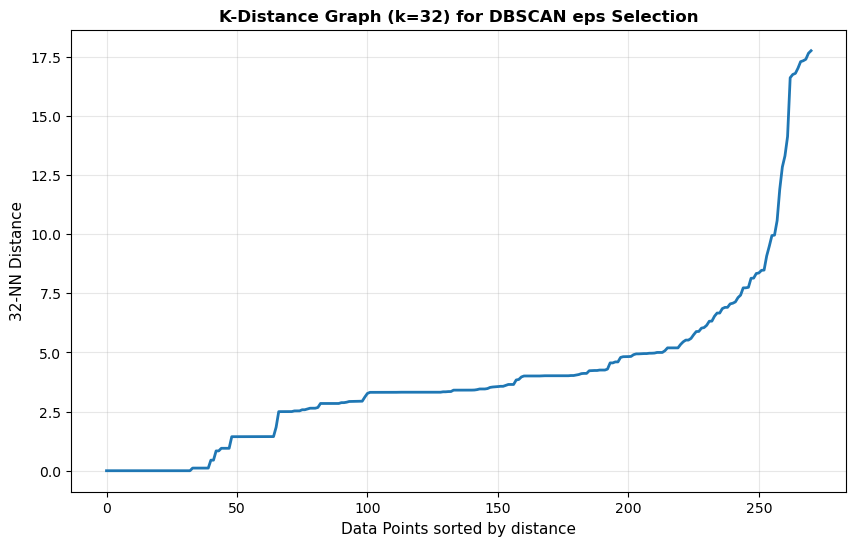


💡 Suggested eps (90th percentile): 7.425


In [15]:
# Find optimal eps using k-distance graph
def plot_k_distance(X, k=32):

    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)
    
    # Sort distances
    distances = np.sort(distances[:, k-1], axis=0)
    
    plt.figure(figsize=(10, 6))
    plt.plot(distances, linewidth=2)
    plt.xlabel('Data Points sorted by distance', fontsize=11)
    plt.ylabel(f'{k}-NN Distance', fontsize=11)
    plt.title(f'K-Distance Graph (k={k}) for DBSCAN eps Selection', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.savefig('k_distance_graph.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Suggest eps based on 90th percentile
    suggested_eps = np.percentile(distances, 90)
    print(f"\n💡 Suggested eps (90th percentile): {suggested_eps:.3f}")
    return suggested_eps

suggested_eps = plot_k_distance(X_scaled, k=32)

In [16]:
# Test different DBSCAN parameters
print("Testing DBSCAN with different parameters...\n")
print(f"{'eps':<8} {'min_samples':<12} {'n_clusters':<12} {'n_noise':<10} {'Silhouette':<12} {'DB Score':<10}")
print("="*80)

dbscan_results = []

# Test different eps values around the suggested one
eps_values = [suggested_eps * 0.7, suggested_eps * 0.85, suggested_eps, suggested_eps * 1.15, suggested_eps * 1.3]
min_samples_values = [32, 35, 7, 10]

for eps in eps_values:
    for min_samp in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samp)
        labels = dbscan.fit_predict(X_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        # Calculate metrics only if we have at least 2 clusters and not all noise
        if n_clusters >= 2 and n_noise < len(labels) - 1:
            # Filter out noise points for silhouette calculation
            mask = labels != -1
            if mask.sum() > 1:
                sil_score = silhouette_score(X_scaled[mask], labels[mask])
                db_score = davies_bouldin_score(X_scaled[mask], labels[mask])
            else:
                sil_score = -1
                db_score = 999
        else:
            sil_score = -1
            db_score = 999
        
        result = {
            'eps': eps,
            'min_samples': min_samp,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': sil_score,
            'db_score': db_score,
            'labels': labels
        }
        dbscan_results.append(result)
        
        print(f"{eps:<8.3f} {min_samp:<12} {n_clusters:<12} {n_noise:<10} {sil_score:<12.3f} {db_score:<10.3f}")

print("\n✓ DBSCAN parameter testing complete")

Testing DBSCAN with different parameters...

eps      min_samples  n_clusters   n_noise    Silhouette   DB Score  
5.198    32           1            38         -1.000       999.000   
5.198    35           1            38         -1.000       999.000   
5.198    7            1            34         -1.000       999.000   
5.198    10           1            34         -1.000       999.000   
6.312    32           1            24         -1.000       999.000   
6.312    35           1            24         -1.000       999.000   
6.312    7            1            19         -1.000       999.000   
6.312    10           1            21         -1.000       999.000   
7.425    32           1            13         -1.000       999.000   
7.425    35           1            13         -1.000       999.000   
7.425    7            1            13         -1.000       999.000   
7.425    10           1            13         -1.000       999.000   
8.539    32           1            13        

In [17]:
# Select best DBSCAN configuration
# Filter valid results (at least 2 clusters, reasonable silhouette)
valid_results = [r for r in dbscan_results if r['n_clusters'] >= 2 and r['silhouette'] > 0]

if len(valid_results) > 0:
    # Choose based on highest silhouette score
    best_dbscan = max(valid_results, key=lambda x: x['silhouette'])
    
    print("\n🎯 BEST DBSCAN CONFIGURATION:")
    print("="*60)
    print(f"eps: {best_dbscan['eps']:.3f}")
    print(f"min_samples: {best_dbscan['min_samples']}")
    print(f"Number of clusters: {best_dbscan['n_clusters']}")
    print(f"Noise points: {best_dbscan['n_noise']} ({best_dbscan['n_noise']/len(X_scaled)*100:.1f}%)")
    print(f"Silhouette Score: {best_dbscan['silhouette']:.3f}")
    print(f"Davies-Bouldin Score: {best_dbscan['db_score']:.3f}")
    
    # Apply best DBSCAN
    dbscan_final = DBSCAN(eps=best_dbscan['eps'], min_samples=best_dbscan['min_samples'])
    dbscan_labels = dbscan_final.fit_predict(X_scaled)
else:
    print("\n⚠️ No valid DBSCAN configuration found. Using default parameters.")
    dbscan_final = DBSCAN(eps=suggested_eps, min_samples=5)
    dbscan_labels = dbscan_final.fit_predict(X_scaled)
    best_dbscan = {
        'eps': suggested_eps,
        'min_samples': 5,
        'n_clusters': len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0),
        'n_noise': list(dbscan_labels).count(-1)
    }


⚠️ No valid DBSCAN configuration found. Using default parameters.


## 8. Apply Final Clustering Models

In [18]:
# Apply K-Means with optimal k
print(f"Applying K-Means with k={optimal_k}...")
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

df_profiles['cluster_kmeans'] = kmeans_labels
df_profiles['cluster_dbscan'] = dbscan_labels

print(f"\n✓ Both clustering algorithms applied")
print(f"\nK-Means cluster distribution:")
print(df_profiles['cluster_kmeans'].value_counts().sort_index())
print(f"\nDBSCAN cluster distribution:")
print(df_profiles['cluster_dbscan'].value_counts().sort_index())
print(f"\nNote: DBSCAN cluster -1 represents noise/outlier points")

Applying K-Means with k=9...

✓ Both clustering algorithms applied

K-Means cluster distribution:
cluster_kmeans
0    125
1     37
2      1
3      2
4     88
5      8
6      1
7      1
8      8
Name: count, dtype: int64

DBSCAN cluster distribution:
cluster_dbscan
-1     13
 0    258
Name: count, dtype: int64

Note: DBSCAN cluster -1 represents noise/outlier points


c:\Users\DELL\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


## 9. Visual Comparison of Clustering Methods

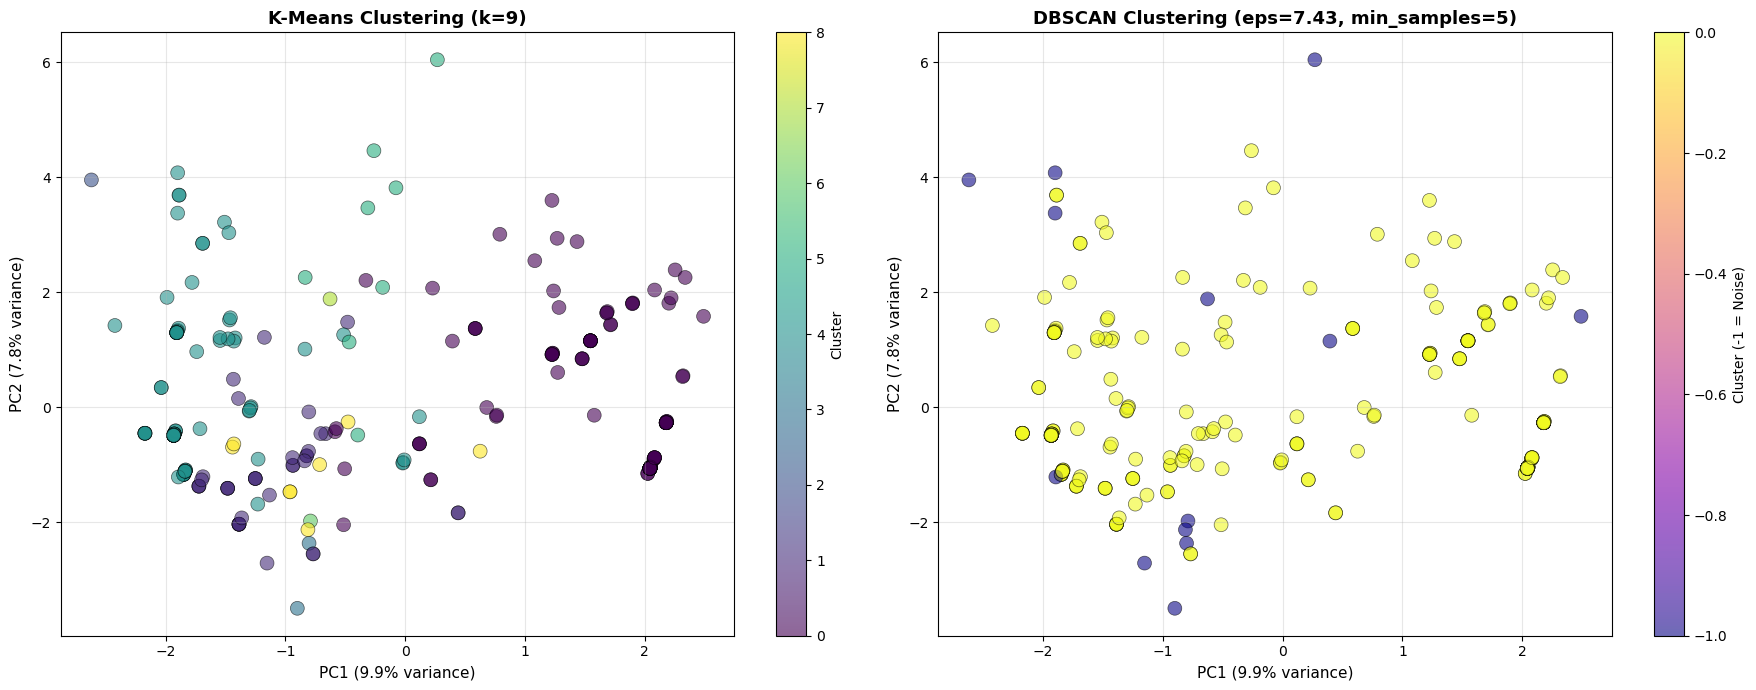

✓ PCA explains 17.7% of total variance
✓ Comparison visualization saved


In [19]:
# Visualize both clustering results using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# K-Means visualization
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
                          c=kmeans_labels, 
                          cmap='viridis', 
                          s=100, 
                          alpha=0.6,
                          edgecolors='black',
                          linewidth=0.5)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
axes[0].set_title(f'K-Means Clustering (k={optimal_k})', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# DBSCAN visualization
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], 
                          c=dbscan_labels, 
                          cmap='plasma', 
                          s=100, 
                          alpha=0.6,
                          edgecolors='black',
                          linewidth=0.5)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
axes[1].set_title(f'DBSCAN Clustering (eps={best_dbscan["eps"]:.2f}, min_samples={best_dbscan["min_samples"]})', 
                 fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster (-1 = Noise)')

plt.tight_layout()
plt.savefig('clustering_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ PCA explains {pca.explained_variance_ratio_.sum():.1%} of total variance")
print("✓ Comparison visualization saved")

## 10. Clustering Performance Comparison

In [20]:
# Compare clustering algorithms
print("\n" + "="*70)
print("CLUSTERING ALGORITHM COMPARISON")
print("="*70)

# K-Means metrics
kmeans_sil = silhouette_score(X_scaled, kmeans_labels)
kmeans_db = davies_bouldin_score(X_scaled, kmeans_labels)
kmeans_ch = calinski_harabasz_score(X_scaled, kmeans_labels)

print("\n📊 K-MEANS:")
print(f"  Number of clusters: {optimal_k}")
print(f"  Silhouette Score: {kmeans_sil:.3f}")
print(f"  Davies-Bouldin Score: {kmeans_db:.3f} (lower is better)")
print(f"  Calinski-Harabasz Score: {kmeans_ch:.2f} (higher is better)")
print(f"  Cluster sizes: {np.bincount(kmeans_labels)}")

# DBSCAN metrics (excluding noise)
mask = dbscan_labels != -1
if mask.sum() > 1 and len(set(dbscan_labels[mask])) > 1:
    dbscan_sil = silhouette_score(X_scaled[mask], dbscan_labels[mask])
    dbscan_db = davies_bouldin_score(X_scaled[mask], dbscan_labels[mask])
    dbscan_ch = calinski_harabasz_score(X_scaled[mask], dbscan_labels[mask])
    
    print("\n📊 DBSCAN:")
    print(f"  Number of clusters: {best_dbscan['n_clusters']}")
    print(f"  Noise points: {best_dbscan['n_noise']} ({best_dbscan['n_noise']/len(X_scaled)*100:.1f}%)")
    print(f"  Silhouette Score: {dbscan_sil:.3f} (excluding noise)")
    print(f"  Davies-Bouldin Score: {dbscan_db:.3f} (lower is better)")
    print(f"  Calinski-Harabasz Score: {dbscan_ch:.2f} (higher is better)")
    
    unique, counts = np.unique(dbscan_labels[mask], return_counts=True)
    print(f"  Cluster sizes (excluding noise): {dict(zip(unique, counts))}")
    
    # Recommendation
    print("\n💡 RECOMMENDATION:")
    if kmeans_sil > dbscan_sil:
        print("  ✅ K-Means performs better (higher silhouette score)")
        print("  📌 Use K-Means for the recommendation system")
        chosen_method = 'kmeans'
    else:
        print("  ✅ DBSCAN performs better (higher silhouette score)")
        print("  📌 Use DBSCAN for the recommendation system")
        chosen_method = 'dbscan'
else:
    print("\n⚠️ DBSCAN did not produce valid clusters")
    print("  📌 Use K-Means for the recommendation system")
    chosen_method = 'kmeans'

print("\n" + "="*70)


CLUSTERING ALGORITHM COMPARISON

📊 K-MEANS:
  Number of clusters: 9
  Silhouette Score: 0.266
  Davies-Bouldin Score: 1.108 (lower is better)
  Calinski-Harabasz Score: 20.11 (higher is better)
  Cluster sizes: [125  37   1   2  88   8   1   1   8]

⚠️ DBSCAN did not produce valid clusters
  📌 Use K-Means for the recommendation system



## 11. Analyze Clusters (Using Best Method)

In [21]:
# Use the chosen clustering method
df_profiles['cluster'] = df_profiles[f'cluster_{chosen_method}']

def analyze_cluster(cluster_id, df_profiles, df_borrowing):
    """
    Analyze characteristics of a specific cluster.
    """
    cluster_users = df_profiles[df_profiles['cluster'] == cluster_id]
    
    if len(cluster_users) == 0:
        return None
    
    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster_id} ANALYSIS ({len(cluster_users)} users)")
    if cluster_id == -1:
        print("(DBSCAN Noise/Outlier Points)")
    print(f"{'='*70}")
    
    # Reader category distribution
    print("\n1. READER CATEGORY DISTRIBUTION:")
    category_dist = cluster_users['Catégorie'].value_counts()
    for cat, count in category_dist.items():
        pct = (count / len(cluster_users)) * 100
        print(f"   {cat}: {count} ({pct:.1f}%)")
    
    # Borrowing behavior
    print("\n2. BORROWING BEHAVIOR:")
    print(f"   Avg books borrowed: {cluster_users['total_borrowed'].mean():.1f}")
    print(f"   Avg borrowing duration: {cluster_users['avg_duration'].mean():.1f} days")
    print(f"   Avg diversity score: {cluster_users['diversity_score'].mean():.1f} categories")
    
    # Top categories borrowed
    print("\n3. TOP BOOK CATEGORIES (by percentage):")
    pct_cols = [col for col in cluster_users.columns if col.endswith('_pct')]
    avg_pcts = cluster_users[pct_cols].mean().sort_values(ascending=False)
    
    top_categories = avg_pcts[avg_pcts > 1].head(5)
    for col, pct in top_categories.items():
        cat_code = col.replace('cat_', '').replace('_pct', '')
        cat_name = CATEGORY_MAPPING.get(cat_code, 'Other')
        print(f"   {cat_name} ({cat_code}): {pct:.1f}%")
    
    return {
        'cluster_id': cluster_id,
        'size': len(cluster_users),
        'dominant_category': category_dist.index[0],
        'avg_books': cluster_users['total_borrowed'].mean(),
        'avg_duration': cluster_users['avg_duration'].mean(),
        'top_book_category': top_categories.index[0].replace('cat_', '').replace('_pct', '') if len(top_categories) > 0 else None
    }

# Analyze all clusters
cluster_summaries = []
for cluster_id in sorted(df_profiles['cluster'].unique()):
    summary = analyze_cluster(cluster_id, df_profiles, df_borrowing)
    if summary:
        cluster_summaries.append(summary)

df_cluster_summary = pd.DataFrame(cluster_summaries)
print(f"\n{'='*70}")
print("CLUSTER SUMMARY TABLE")
print(f"{'='*70}")
print(df_cluster_summary.to_string(index=False))


CLUSTER 0 ANALYSIS (125 users)

1. READER CATEGORY DISTRIBUTION:
   1 ére ANNEE: 118 (94.4%)
   4 éme ANNEE: 7 (5.6%)

2. BORROWING BEHAVIOR:
   Avg books borrowed: 1.7
   Avg borrowing duration: 16.1 days
   Avg diversity score: 1.4 categories

3. TOP BOOK CATEGORIES (by percentage):
   Algèbre (512): 69.6%
   Programmation / logiciels (005): 10.4%
   Mathématiques générales (510): 8.3%
   Analyse / calcul (515): 3.1%
   Génie / ingénierie (621): 1.9%

CLUSTER 1 ANALYSIS (37 users)

1. READER CATEGORY DISTRIBUTION:
   3 ème ANNEE: 35 (94.6%)
   4 éme ANNEE: 2 (5.4%)

2. BORROWING BEHAVIOR:
   Avg books borrowed: 1.3
   Avg borrowing duration: 10.4 days
   Avg diversity score: 1.1 categories

3. TOP BOOK CATEGORIES (by percentage):
   Analyse / calcul (515): 31.1%
   Probabilités et statistiques (519): 18.0%
   Programmation / logiciels (005): 12.2%
   Mathématiques générales (510): 10.8%
   Intelligence artificielle (006): 8.1%

CLUSTER 2 ANALYSIS (1 users)

1. READER CATEGORY DISTRI

## 12. Build Recommendation System

In [22]:
def get_recommendations(user_category, df_profiles, df_borrowing, top_n=10):
    """
    Generate book recommendations based on user's reader category.
    """
    print(f"\nGenerating recommendations for: {user_category}")
    print("=" * 70)
    
    # Filter out noise cluster if using DBSCAN
    df_profiles_clean = df_profiles[df_profiles['cluster'] != -1]
    
    # Step 1: Find users with the same category
    same_category_users = df_profiles_clean[df_profiles_clean['Catégorie'] == user_category]
    
    if len(same_category_users) == 0:
        print(f"No users found in category: {user_category}")
        return None
    
    # Step 2: Find the most common cluster for this category
    cluster_distribution = same_category_users['cluster'].value_counts()
    target_cluster = cluster_distribution.index[0]
    
    print(f"\nTarget cluster: {target_cluster}")
    print(f"Users in this category-cluster: {cluster_distribution.iloc[0]}")
    
    # Step 3: Get all users in the target cluster
    cluster_users = df_profiles_clean[df_profiles_clean['cluster'] == target_cluster]['N° lecteur'].values
    
    # Step 4: Find popular books in this cluster
    cluster_borrowings = df_borrowing[df_borrowing['N° lecteur'].isin(cluster_users)]
    
    # Find the most common book category in this cluster
    top_category = cluster_borrowings['book_category'].value_counts().index[0]
    top_category_name = CATEGORY_MAPPING.get(top_category, 'Other')
    
    print(f"\nMost popular book category in cluster: {top_category_name} ({top_category})")
    
    # Step 5: Get popular books from this category
    category_books = cluster_borrowings[cluster_borrowings['book_category'] == top_category]
    
    popular_books = (category_books.groupby(['Numéro', 'Titre_clean'])
                     .size()
                     .reset_index(name='borrow_count')
                     .sort_values('borrow_count', ascending=False)
                     .head(top_n))
    
    print(f"\n📚 TOP {len(popular_books)} POPULAR BOOKS (Most Borrowed):")
    print("-" * 70)
    for idx, row in popular_books.iterrows():
        print(f"{row['borrow_count']:3d}× - {row['Titre_clean'][:60]}")
    
    # Step 6: Find unexplored books
    all_books_in_category = df_borrowing[df_borrowing['book_category'] == top_category]
    book_counts = all_books_in_category.groupby(['Numéro', 'Titre_clean']).size()
    
    unexplored_books = book_counts[book_counts <= 2].reset_index(name='borrow_count')
    unexplored_sample = unexplored_books.sample(min(5, len(unexplored_books)), random_state=42)
    
    print(f"\n🔍 UNEXPLORED BOOKS (You might discover):")
    print("-" * 70)
    for idx, row in unexplored_sample.iterrows():
        print(f"    - {row['Titre_clean'][:60]} (borrowed {row['borrow_count']}× only)")
    
    return {
        'user_category': user_category,
        'target_cluster': target_cluster,
        'cluster_size': len(cluster_users),
        'top_category': top_category,
        'top_category_name': top_category_name,
        'popular_books': popular_books,
        'unexplored_books': unexplored_sample
    }

print("✓ Recommendation function defined")

✓ Recommendation function defined


## 13. Test Recommendations

In [23]:
# Test recommendations for different reader categories
available_categories = df_profiles['Catégorie'].unique()

print("Available reader categories:")
for i, cat in enumerate(available_categories, 1):
    print(f"{i}. {cat}")

# Test for first category
test_category = available_categories[0]

recommendations = get_recommendations(
    user_category=test_category,
    df_profiles=df_profiles,
    df_borrowing=df_borrowing,
    top_n=10
)

Available reader categories:
1. 1 ére ANNEE
2. 3 ème ANNEE
3. Enseignant
4. 2 éme ANNEE
5. 4 éme ANNEE
6. Employé

Generating recommendations for: 1 ére ANNEE

Target cluster: 0
Users in this category-cluster: 118

Most popular book category in cluster: Algèbre (512)

📚 TOP 10 POPULAR BOOKS (Most Borrowed):
----------------------------------------------------------------------
  1× - ALGORITHMIQUE COURS ET EXERCICES CORRIGES
  1× - ALGEBRE 1 RAPPELS DE COURS ET EXERCICES AVEC SOLUTIONS
  1× - ALGEBRE 1 RAPPELS DE COURS ET EXERCICES AVEC SOLUTIONS
  1× - ALGEBRE 1 RAPPELS DE COURS ET EXERCICES AVEC SOLUTIONS
  1× - ALGEBRE 1 RAPPELS DE COURS ET EXERCICES AVEC SOLUTIONS
  1× - ALGEBRE 1 RAPPELS DE COURS ET EXERCICES AVEC SOLUTIONS
  1× - ALGEBRE 1 RAPPELS DE COURS ET EXERCICES AVEC SOLUTIONS
  1× - ALGEBRE 1 RAPPELS DE COURS ET EXERCICES AVEC SOLUTIONS
  1× - ALGEBRE 1 RAPPELS DE COURS ET EXERCICES AVEC SOLUTIONS
  1× - ALGEBRE 1RE ANNEE

🔍 UNEXPLORED BOOKS (You might discover):
--------

## 14. Save Results

In [24]:
# Save all results
df_profiles.to_csv('user_profiles_with_clusters_improved.csv', index=False)
df_cluster_summary.to_csv('cluster_summary_improved.csv', index=False)

# Save model
import pickle

model_data = {
    'kmeans_model': kmeans_final,
    'dbscan_params': {'eps': best_dbscan['eps'], 'min_samples': best_dbscan['min_samples']},
    'scaler': scaler,
    'feature_columns': X_full.columns.tolist(),
    'category_mapping': CATEGORY_MAPPING,
    'optimal_k': optimal_k,
    'chosen_method': chosen_method,
    'pca': pca
}

with open('recommendation_model_improved.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("✓ All results saved:")
print("  - user_profiles_with_clusters_improved.csv")
print("  - cluster_summary_improved.csv")
print("  - recommendation_model_improved.pkl")
print("  - kmeans_evaluation.png")
print("  - k_distance_graph.png")
print("  - clustering_comparison.png")

✓ All results saved:
  - user_profiles_with_clusters_improved.csv
  - cluster_summary_improved.csv
  - recommendation_model_improved.pkl
  - kmeans_evaluation.png
  - k_distance_graph.png
  - clustering_comparison.png


## 15. Summary and Insights

In [25]:
print("\n" + "="*70)
print("PROJECT SUMMARY - IMPROVED VERSION")
print("="*70)

print(f"\n✓ Dataset: {len(df_borrowing)} borrowing records")
print(f"✓ Users profiled: {len(df_profiles)}")
print(f"✓ Reader categories: {df_profiles['Catégorie'].nunique()}")
print(f"✓ Book categories: {len(CATEGORY_MAPPING)}")

print("\n📊 CLUSTERING RESULTS:")
print(f"   K-Means clusters: {optimal_k}")
print(f"   DBSCAN clusters: {best_dbscan['n_clusters']} (+ {best_dbscan['n_noise']} noise points)")
print(f"   Chosen method: {chosen_method.upper()}")

print("\n🔧 IMPROVEMENTS MADE:")
print("   1. ✅ One-hot encoding for reader categories (better than label encoding)")
print("   2. ✅ DBSCAN clustering added for comparison")
print("   3. ✅ Multiple evaluation metrics (Silhouette, DB, CH scores)")
print("   4. ✅ Visual comparison of clustering methods")
print("   5. ✅ Automatic selection of best clustering method")

print("\n💡 KEY FINDINGS:")
print(f"   - PCA captures {pca.explained_variance_ratio_.sum():.1%} of variance in 2 components")
print(f"   - Clustering separates users into {len(df_cluster_summary)} meaningful groups")
print(f"   - Recommendation system can now serve {df_profiles['Catégorie'].nunique()} reader categories")

print("\n🎯 RECOMMENDATION SYSTEM READY")
print("   Use: get_recommendations(user_category, ...) to get personalized book suggestions")

print("\n" + "="*70)


PROJECT SUMMARY - IMPROVED VERSION

✓ Dataset: 422 borrowing records
✓ Users profiled: 271
✓ Reader categories: 6
✓ Book categories: 21

📊 CLUSTERING RESULTS:
   K-Means clusters: 9
   DBSCAN clusters: 1 (+ 13 noise points)
   Chosen method: KMEANS

🔧 IMPROVEMENTS MADE:
   1. ✅ One-hot encoding for reader categories (better than label encoding)
   2. ✅ DBSCAN clustering added for comparison
   3. ✅ Multiple evaluation metrics (Silhouette, DB, CH scores)
   4. ✅ Visual comparison of clustering methods
   5. ✅ Automatic selection of best clustering method

💡 KEY FINDINGS:
   - PCA captures 17.7% of variance in 2 components
   - Clustering separates users into 9 meaningful groups
   - Recommendation system can now serve 6 reader categories

🎯 RECOMMENDATION SYSTEM READY
   Use: get_recommendations(user_category, ...) to get personalized book suggestions

